In [1]:
# Importing the required libraries
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import cv2

In [2]:
# The 3 classes
labels = ['COVID', 'NORMAL', 'PNEUMONIA']

# The image size is 256*256
img_size = 256

# Returns a list containing pairs of resized image arrays and their respective class numbers (0,1,2) for (COVID, NORMAL, PNEUMONIA)
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label).replace("\\", "/")
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img).replace("\\", "/")
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size))
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data, dtype=object)

In [3]:
# Training data 80%
train = get_data('DataSet/Train') 
# Validation data 10%
val = get_data('DataSet/Validation')
# Testing data 10%
test = get_data('DataSet/Test')

# Data Preprocessing

## Organizing and Splitting Data

In [4]:
# Contain the features and labels for the training set
x_train = []
y_train = []
# Contain the features and labels for the validation set
x_val = []
y_val = []
# Contain the features and labels for the testing set
x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature) # Represents the image data
    y_train.append(label)  # Represents the class label associated with the image
    
for feature, label in val:
    x_val.append(feature) # Represents the image data
    y_val.append(label) # Represents the class label associated with the image

for feature, label in test:
    x_test.append(feature) # Represents the image data
    y_test.append(label) # Represents the class label associated with the image



## Normalizing the data

In [5]:
# Normalization : Converts the image pixel values from the range [0, 255] to a normalized range [0, 1]
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

## Data Augmentation


In [6]:
# Data augmentation is a technique used to artificially increase the diversity of the training dataset
# by applying various transformations to the existing images.
# This helps the model generalize better to new, unseen data and reduce overfitting.

datagen = ImageDataGenerator(rotation_range = 30,  
        zoom_range = 0.2,
        width_shift_range=0.1,  
        height_shift_range=0.1,
        horizontal_flip = True) 

datagen.fit(x_train)

# Training the Model


In [7]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(img_size, img_size, 1))) # The input is a grayscale image
model.add(MaxPool2D(pool_size=(2, 2))) # Reduce spatial dimension

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPool2D(pool_size=(2, 2)))

model.add(Flatten()) # Transforms 2D to 1D
model.add(Dense(64, activation='relu')) 
model.add(Dense(3, activation='softmax')) # Output layer => 3 classes

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'],run_eagerly=True)
model.summary()





Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 246016)            0         
                                                                 
 dense (Dense)               (None, 64)              

In [8]:
# The original labels were integers representing classes ( 0, 1, 2 for COVID, NORMAL, PNEUMONIA)
# to_categorical converts these into arrays where each element corresponds to a class,
# and the label is marked as 1 in the respective class position while other positions are 0s.
from keras.callbacks import EarlyStopping

y_train_encoded = to_categorical(y_train,num_classes=3)
y_val_encoded = to_categorical(y_val,num_classes=3)
# Define an EarlyStopping callback to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
#  Training the neural network model using the prepared data
model.fit(datagen.flow(x_train, y_train_encoded, batch_size=128), epochs=15, verbose=1, validation_data=datagen.flow(x_val, y_val_encoded),callbacks=[early_stopping])

Epoch 1/15

28/28 [==============================] - 109s 3s/step - loss: 1.8993 - accuracy: 0.4849 - val_loss: 0.6705 - val_accuracy: 0.6846
Epoch 2/15
28/28 [==============================] - 88s 3s/step - loss: 0.5835 - accuracy: 0.7667 - val_loss: 0.4760 - val_accuracy: 0.8177
Epoch 3/15
28/28 [==============================] - 90s 3s/step - loss: 0.4582 - accuracy: 0.8184 - val_loss: 0.3972 - val_accuracy: 0.8509
Epoch 4/15
28/28 [==============================] - 93s 3s/step - loss: 0.3832 - accuracy: 0.8600 - val_loss: 0.4385 - val_accuracy: 0.8406
Epoch 5/15
28/28 [==============================] - 114s 4s/step - loss: 0.3598 - accuracy: 0.8697 - val_loss: 0.4043 - val_accuracy: 0.8429
Epoch 6/15
28/28 [==============================] - 112s 4s/step - loss: 0.3776 - accuracy: 0.8551 - val_loss: 0.3966 - val_accuracy: 0.8601
Epoch 7/15
28/28 [==============================] - 106s 4s/step - loss: 0.3421 - accuracy: 0.8783 - val_loss: 0.4074 - val_accuracy: 0.8555
Epoch 8/15
28/2

In [9]:
# Assuming y_test is your original class labels (not one-hot encoded)
y_test_encoded = to_categorical(y_test, num_classes=3)

# Evaluate the model on the test set
evaluation_result = model.evaluate(x_test, y_test_encoded)

# Print the loss and accuracy
print("Loss of the model is -", evaluation_result[0])
print("Accuracy of the model is -", evaluation_result[1] * 100, "%")


28/28 [==============================] - 7s 247ms/step - loss: 0.3790 - accuracy: 0.9104
Loss of the model is - 0.3789815902709961
Accuracy of the model is - 91.04477763175964 %


# Predictions

In [10]:
# Generate predictions
# WIll be used to calculate confusion matrix
predictions = model.predict(x_test)
predictions = predictions.argmax(axis=1)

28/28 [==============================] - 7s 233ms/step


# Interface

In [14]:
from PIL import Image

def preprocess_image(image_path):
    # Open the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # Resize the image
    img = cv2.resize(img, (256,256))
    # Normalize the pixel values to be in the range [0, 1]
    img_array = np.array(img) / 255
    # Add a batch dimension and reshape to match the model's input shape
    img_array = np.expand_dims(img_array, axis=0)  # (1, 256, 256, 1)

    return img_array

In [15]:
def process_image(image_path):
    # The output image will be a grayscale, resized, normalized, and reshaped representation of the original image
    preprocessed_image = preprocess_image(image_path)

    # Make prediction on the single preprocessed image
    prediction = model.predict(preprocessed_image)

    # Get the index of the predicted class
    predicted_class = prediction.argmax()
    return predicted_class


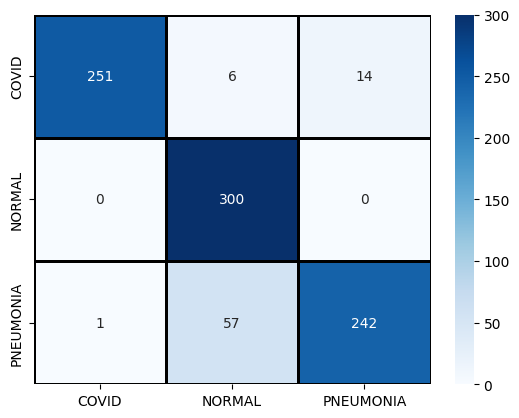

In [16]:
import tkinter as tk
from tkinter import filedialog
from PIL import ImageTk, Image
from sklearn.metrics import classification_report,confusion_matrix


root = tk.Tk()
root.title("Lung Illness Detection")

# Get the screen width and height
screen_width = root.winfo_screenwidth()
screen_height = root.winfo_screenheight()

# Calculate the frame width and height as 75% of the screen
frame_width = int(screen_width * 0.75)
frame_height = int(screen_height * 0.75)

# Set the frame dimensions
root.geometry(f"{frame_width}x{frame_height}")

frame = tk.Frame(root, bg='#CEDDD9', width=frame_width, height=frame_height)
frame.pack_propagate(False)  # Disable frame auto-resizing
frame.grid_propagate(False)  # Disable grid resizing
frame.grid_rowconfigure(0, weight=1)  # Make row expandable
frame.grid_columnconfigure(0, weight=1)  # Make column expandable

lbl_show_pic = tk.Label(frame, bg='#CEDDD9') #Label of the selected image
lbl_show_predictedClass = tk.Label(frame, bg='#CEDDD9', fg='#297C65', font=('verdana', 14, 'bold'))
entry_show_predictedClass = tk.Entry(frame, font=('verdana',16)) #Value of the predicted class
btn_browse = tk.Button(frame, text='Select Image', bg='grey', fg='#ffffff', font=('verdana', 16)) #Button select image
btn_predict = tk.Button(frame, text='Predict', bg='#50AD94', fg='#ffffff', font=('verdana', 16)) #Button predict


# The window that contains Accuracy and confusion matrix
def open_new_window():
    new_window = tk.Toplevel(root)
    new_window.title("Informations")

    # Get the dimensions of the root frame
    root_frame_width = frame.winfo_width()
    root_frame_height = frame.winfo_height()

    new_window.geometry(f"{root_frame_width}x{root_frame_height}")

    frame1 = tk.Frame(new_window, bg='#CEDDD9', width=root_frame_width, height=root_frame_height)
    frame1.pack_propagate(False)  # Disable frame auto-resizing
    frame1.grid_propagate(False)  # Disable grid resizing
    frame1.grid_rowconfigure(0, weight=1) # Make row expandable
    frame1.grid_columnconfigure(0, weight=1)  # Make column expandable

    # Label of accuracy
    lbl_accuracy = tk.Label(frame1,text="Accuracy of the model is : ", bg='#CEDDD9', fg='#297C65', font=('verdana', 14, 'bold'))
    lbl_value_accuracy = tk.Label(frame1,text=f"{evaluation_result[1] * 100:.2f}%", bg='#CEDDD9', fg='#000000', font=('verdana', 12, 'bold'))
    lbl_accuracy.pack()
    lbl_value_accuracy.pack()

    # Confusion matrix
    cm = confusion_matrix(y_test, predictions)
    labels = ['COVID', 'NORMAL', 'PNEUMONIA']

    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=labels, columns=labels)

    # Create a heatmap
    sns.heatmap(cm_df, cmap="Blues", linecolor='black', linewidth=1, annot=True, fmt='', xticklabels=labels, yticklabels=labels)

    # Save the plot as an image
    plt.savefig('confusion_matrix.png') 

    # Display the confusion matrix image in the new window
    img1 = Image.open('confusion_matrix.png')
    img1 = img1.resize((512, 512), Image.ANTIALIAS)
    img1 = ImageTk.PhotoImage(img1)

    # Label of confusion matrix
    lbl_matrice_confusion = tk.Label(frame1, text="Confusion Matrix : ", bg='#CEDDD9', fg='#297C65', font=('verdana', 14, 'bold'))
    lbl_matrice_confusion.pack()
    lbl_show_matrice_confusion = tk.Label(frame1, bg='#CEDDD9', image=img1)
    lbl_show_matrice_confusion.image = img1 
    lbl_show_matrice_confusion.pack()

    frame1.pack()

# On Hover button Informations
class ToolTip:
    def __init__(self, widget, text):
        self.widget = widget
        self.text = text
        self.tooltip_window = None
        self.widget.bind("<Enter>", self.show_tooltip)
        self.widget.bind("<Leave>", self.hide_tooltip)

    def show_tooltip(self, event=None):
        x, y, _, _ = self.widget.bbox("insert")
        x += self.widget.winfo_rootx() + 25
        y += self.widget.winfo_rooty() + 25

        self.tooltip_window = tk.Toplevel(self.widget)
        self.tooltip_window.wm_overrideredirect(True)
        self.tooltip_window.wm_geometry(f"+{x}+{y}")

        label = tk.Label(self.tooltip_window, text=self.text, bg="#ffffff", relief="solid", borderwidth=1)
        label.pack()

    def hide_tooltip(self, event=None):
        if self.tooltip_window:
            self.tooltip_window.destroy()
            self.tooltip_window = None

# Create the tooltip for the button
tooltip_text = "Show accuracy and confusion matrix"
btn_show_info = ImageTk.PhotoImage(file='info.png')
btn_info = tk.Button(frame, bg='#CEDDD9', image=btn_show_info, command=open_new_window)
btn_info.grid(row=4, column=0, sticky=tk.SE)
tooltip = ToolTip(btn_info, tooltip_text)

# Create space from the bottom and right edges
frame.grid_rowconfigure(5, minsize=20)
frame.grid_columnconfigure(1, minsize=20) 

# Will contain the selected image path
filename=""

# Function called when we select an image
def selectPic():
    global img, filename
    filename = filedialog.askopenfilename(initialdir="/images", title="Select Image",
                                          filetypes=(("png images", "*.png"), ("jpg images", "*.jpg")))
    # Display the image
    img = Image.open(filename)
    img = img.resize((256, 256), Image.ANTIALIAS)
    img = ImageTk.PhotoImage(img)
    lbl_show_pic['image'] = img
    lbl_show_pic.grid(row=0, column=0, padx=20, pady=20, sticky=tk.W + tk.E + tk.N + tk.S)
    # Display a new button to predict the image's class
    btn_predict.grid(row=2, column=0, padx=10, pady=10, sticky=tk.N)

# Function called when we press the predict button
def predictPic():
    # Display predicted class
     lbl_show_predictedClass.grid(row=3, column=0, padx=20, pady=20, sticky=tk.W + tk.E + tk.N + tk.S)
     predicted_class = process_image(filename)
     lbl_show_predictedClass.config(text="Predicted class : "+labels[predicted_class])


btn_browse['command'] = selectPic # Select image button
btn_predict['command'] = predictPic # Predict class button

# Display the select image button
btn_browse.grid(row=1, column=0, padx=10, pady=10, sticky=tk.N)

frame.pack()

root.mainloop()